# Playback with  `MPC dataset` and `Ground Truth`

In [1]:
import torch
import mujoco
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from util import rpy2r, r2quat, r2rpy, quat2r
import pickle
import mediapy as media
from util import rpy2r,MultiSliderClass,create_folder_if_not_exists,slerp
import cv2,glob,os

from policy import GaussianPolicy

np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
# %matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Load `MPC motion`

In [2]:
motion_name = 'SMPL_MPC_motion_240502'
with open(file='../data/%s.pkl'%(motion_name), mode='rb') as f:
    dataset = pickle.load(f)

horizon = 200
skip_beginning = 0

action_batch = np.array(dataset['action'])
L = action_batch.shape[0] # actual dataset size
size = L # selected size (front slice)

qpos_batch = np.array(dataset['qpos'])
qvel_batch = np.array(dataset['qvel'])

action_batch = action_batch.reshape(L, horizon, -1)[:size, skip_beginning:, :]#.reshape(size*horizon, -1)
qpos_batch = qpos_batch.reshape(L, horizon, -1)[:size, skip_beginning:, :]#.reshape(size*horizon, -1)
qvel_batch = qvel_batch.reshape(L, horizon, -1)[:size, skip_beginning:, :]#.reshape(size*horizon, -1)

# corrupted_idx = np.where(action_batch == None)[1]
corrupted_idx   = np.where(action_batch == None)[0]
size -= len(corrupted_idx)
action_batch    = np.ma.array(action_batch, mask=False)
action_batch.mask[corrupted_idx] = True
action_batch    = action_batch.compressed().reshape(-1,horizon,action_batch.shape[-1]).reshape(-1,action_batch.shape[-1])

qpos_batch      = np.ma.array(qpos_batch, mask=False)
qpos_batch.mask[corrupted_idx] = True
qpos_batch      = qpos_batch.compressed().reshape(-1,horizon,qpos_batch.shape[-1]).reshape(-1,qpos_batch.shape[-1])

qvel_batch      = np.ma.array(qvel_batch, mask=False)
qvel_batch.mask[corrupted_idx] = True
qvel_batch      = qvel_batch.compressed().reshape(-1,horizon,qvel_batch.shape[-1]).reshape(-1,qvel_batch.shape[-1])

# qpos_batch = torch.cat((qpos_batch[:-2, :],qpos_batch[1:-1, :],qpos_batch[2:, :]),dim=1)
# qvel_batch = torch.cat((qvel_batch[:-2, :],qvel_batch[1:-1, :],qvel_batch[2:, :]),dim=1)

root_pos = qpos_batch[:, :3]
root_rot = qpos_batch[:, 3:7]
root_vel = qvel_batch[:, :3]
root_ang_vel = qvel_batch[:, 3:6]
dof_pos = qpos_batch[:, 7:44]
dof_vel = qvel_batch[:, 6:43]

dataset = {
    "root_pos": root_pos,
    "root_rot": root_rot,
    "root_vel": root_vel,
    "root_ang_vel": root_ang_vel,
    "dof_pos": dof_pos,
    "dof_vel": dof_vel,
    # "key_pos": None,
    "action": action_batch
}

N = qpos_batch.shape[0]

print("obs : ", qpos_batch.shape)
print("action : ", action_batch.shape)


obs :  (39800, 44)
action :  (39800, 37)


In [3]:
xml_path = '../asset/smpl_rig/scene_smpl_rig.xml'
env = MuJoCoParserClass(name='smplrig',rel_xml_path=xml_path,VERBOSE=True)
# Modify the color of body exluding 'world'
for body_name in env.body_names:
    if body_name in ['world']: continue
    body_idx = env.body_names.index(body_name)
    geom_idxs = [idx for idx,val in enumerate(env.model.geom_bodyid) if val==body_idx]
    for geom_idx in geom_idxs:
        env.model.geom(geom_idx).rgba = [0.3,0.3,0.5,0.5]
print ("Done.")

dt:[0.0083] HZ:[120]
n_dof (=nv):[43]
n_geom:[67]
geom_names:['floor', 'base', 'base2lpelvis', 'base2rpelvis', 'base2spine1', 'spine2spine', 'spine2spine2', 'spine2spine3', 'spine2lcollar', 'spine2rcollar', 'neck2head', 'head', 'nose', 'lcollar2lshoulder', 'lshoulder2lelbow', 'lelbow2lwrist', 'lwrist2lindex1', 'lwrist2lmiddle1', 'lwrist2lpinky1', 'lwrist2lring1', 'lwrist2lthumb1', 'lindex1-lindex2', 'lindex2-lindex3', 'lindex3-lindextip', 'lmiddle1-lmiddle2', 'lmiddle2-lmiddle3', 'lmiddl3-lmiddletip', 'lring1-lring2', 'lring2-lring3', 'lring3-lringtip', 'lpinky1-lpinky2', 'lpinky2-lpinky3', 'lpinky3-lpinkytip', 'lthumb1-lthumb2', 'lthumb2-lthumb3', 'lthumb3-lthumbtip', 'rcollar2rshoulder', 'rshoulder2relbow', 'relbow2rwrist', 'rwrist2rindex1', 'rwrist2rmiddle1', 'rwrist2rpinky1', 'rwrist2rring1', 'rwrist2rthumb1', 'rindex1-rindex2', 'rindex2-rindex3', 'rindex3-rindextip', 'rmiddle1-rmiddle2', 'rmiddle2-rmiddle3', 'rmiddle3-rmiddletip', 'rring1-rring2', 'rring2-rring3', 'rring3-rringtip

In [4]:
KEY_BODY_NAMES = ["right_ankle", "left_ankle", "right_wrist", "left_wrist"]
key_body_ids= np.array(env.get_idxs_body(KEY_BODY_NAMES))

In [5]:
# Set which joints to control
ctrl_joint_names = env.ctrl_joint_names # <==
joint_idxs_fwd = env.get_idxs_fwd(joint_names=ctrl_joint_names)
joint_idxs_jac = env.get_idxs_jac(joint_names=ctrl_joint_names)
q_ctrl_init = env.get_qpos_joints(ctrl_joint_names)
n_ctrl_joint = len(ctrl_joint_names)

In [6]:
PLOT_EVERY  = 4
print ("PLOT_EVERY:[%d] "%(PLOT_EVERY))

PLOT_EVERY:[4] 


### Playback and Reconstruct Observation

In [7]:
# Initialize MuJoCo viewer
env.init_viewer(viewer_title='SMPL',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=False)
env.update_viewer(azimuth=152,distance=3.0,elevation=-20,lookat=[0.02,-0.03,1.2])
env.reset()

key_pos_batch = np.zeros(((size)*(horizon-skip_beginning), 4, 3))

for t in range(0,size):
    for h in range(horizon-skip_beginning):
        qpos = qpos_batch[(horizon-skip_beginning)*t+h]
        env.forward(qpos)

        # key_pos_batch[(horizon-skip_beginning),h] = env.data.xpos[key_body_ids]
        key_pos_batch[(horizon-skip_beginning)*t+h] = env.data.xpos[key_body_ids]
    
        if env.loop_every(tick_every=1):
            # Plot world frame
            env.plot_T(p=np.zeros(3),R=np.eye(3,3),
                    PLOT_AXIS=True,axis_len=0.5,axis_width=0.005)
            env.plot_T(p=np.array([0,0,0.5]),R=np.eye(3,3),
                    PLOT_AXIS=False,label="tick:[%d]"%(env.tick))

            # Key body
            for p_GT in env.data.xpos[key_body_ids]:
                env.plot_sphere(p=p_GT,r=0.02,rgba=[1,0.2,0.2,1])
            
            # env.render()
env.close_viewer()

### Compute Reward

In [8]:
# dataset['key_pos'] = key_pos_batch

local_key_pos_batch = key_pos_batch - np.expand_dims(root_pos, 1)
dataset['local_key_pos'] = local_key_pos_batch

dataset.keys()

dict_keys(['root_pos', 'root_rot', 'root_vel', 'root_ang_vel', 'dof_pos', 'dof_vel', 'action', 'local_key_pos'])

dtype('O')

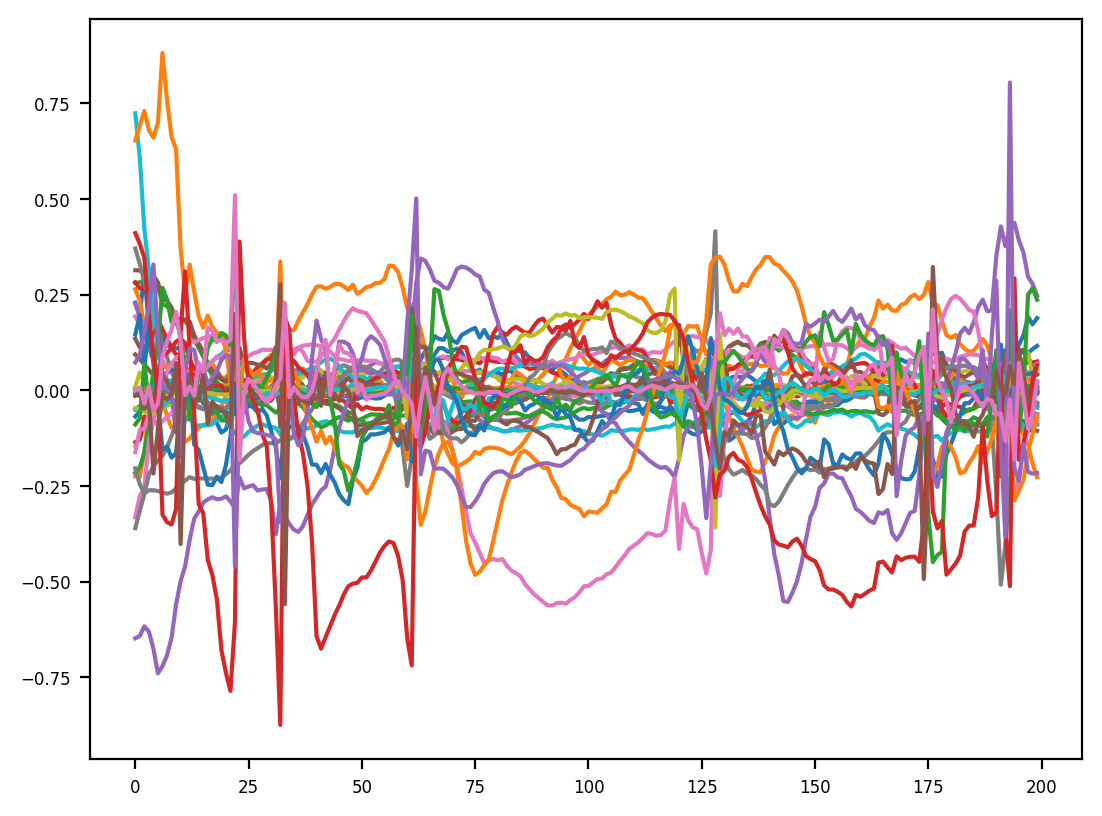

In [9]:
plt.plot(dataset['action'][:200,:])

dataset['action'].dtype

In [10]:
dataset_name = '%s'%(motion_name.replace('motion', 'dataset'))
with open(file='../data/%s.pkl'%dataset_name, mode='wb') as f:
    pickle.dump(dataset, f)
print ("[../data/%s.pkl] saved."%(dataset_name))

[../data/SMPL_MPC_dataset_240502.pkl] saved.
